In [1]:
import os

In [9]:
os.system("python RNN_QSR.py L=100 M=0.9 hamiltonian=TFIM h=-1.0 J=1.0 K=1 Q=1 USEQUEUE=0 dir=SUS steps=4000")

0

In [34]:
os.system("python RNN_QSR.py L=100 hamiltonian=TFIM h=-1.0 J=1.0 K=2 Q=1 USEQUEUE=0 dir=SUS steps=4000")

0

# Example of how to run the training script with command line args

In [ ]:
import os
for L,loops in [(10,1),(40,1),(100,1),(500,4),(36,1)]:#[10,40,100,500]:
    for M in [31/32,0.1,0.5,0.9,0.99]:
        os.system("python RNN_QSR.py L=%d M=%f hamiltonian=TFIM h=-1.0 J=1.0 K=32 NLOOPS=%d"%(L,M,loops))

# More finalized plotting function

In [154]:
import os
import numpy as np
from matplotlib import pyplot as plt
import RNN_QSR
def getpaths(fn, include=[],alldir=False):
    """Looks in the directory folder and returns all paths in a dictionary which groups by system size
    Inputs:
        fn - The directory name you want to get all the folder paths from
        include - a list of keystrings which must be included in any path you search
    Outputs:
        A dictionary of L:[paths] pairs.
    """
    allpaths=dict()
    for paths,folders,files in os.walk(fn):
        #print(paths)
        Lcomp=paths.split("-")[0].split("\\")
        if len([a for a in include if a in paths])!=len(include):continue
        if len(paths.split("\\")[-1].split("-"))==1 and not alldir:continue
        if len(Lcomp)>2:
            Lcomp=int(Lcomp[2]) 
            if not Lcomp in allpaths:
                allpaths[Lcomp]=[paths]
            else:
                allpaths[Lcomp]+=[paths]
    return allpaths
allpaths=getpaths("out\\TFIM")      
print(allpaths.keys())


def errplt(out,*args,**kwargs):
    """Plots with nice error bars"""
    fmt=None
    
    args = [a for a in args]
    for i in range(len(args)):
        if type(args[i])==type(str()):fmt=args[i];del args[i]
    if len(args)<2:in_=np.arange(out.shape[0])
    if len(args)==1:errs=args[0]
    if len(args)==2:in_,out,errs=out,args[0],args[1]
    if len(args)>0:        
        if fmt!= None:
            plt.plot(in_,out,fmt,**kwargs)
            if not "color" in kwargs:
                c=fmt[0]
            else:
                c=kwargs["color"]
            plt.fill_between(in_,out-errs,out+errs,color=c,alpha=0.4,lw=0.0)
        else:
            plt.plot(in_,out,**kwargs)
            plt.fill_between(in_,out-errs,out+errs,alpha=0.4)
            

def graphs(allpaths,useTimes=False, metric="Sample",label_idx=1,err=False,smoothing=100):
    idx = {"SAMPLE":5,"CORRECTED":3,"TRAIN":1}[metric.upper()]
    for key in sorted(allpaths.keys()):

        fig = plt.figure(1,figsize=(6,2.5), dpi=240, facecolor='w', edgecolor='k')
        plt.title("L = %d %s Energy"%(key,metric))
        if key in RNN_QSR.TFIM.En1:
            exact_energy=RNN_QSR.TFIM.En1[key]
            
            if err:
                plt.ylim(-1e-3,5e-3)
            else:
                plt.yscale("log")
                plt.ylim(1e-5,5)
            
        elif key in RNN_QSR.Rydberg.E:
            exact_energy=RNN_QSR.Rydberg.E[key]
            if False:
                plt.ylim(-5e-3,1e-2)
            elif err:
                plt.ylim(-1e-2,3e-2)
            else:
                plt.yscale("log")
                plt.ylim(1e-5,5)
            
        else:
            plt.ylim(-1.28,-1.25)
            exact_energy=0

        print(key in RNN_QSR.Rydberg.E,exact_energy)
        bestmin=1e-5
        ends=[]
        for path in allpaths[key]:
            try:
                DEBUG = np.load(path+"\\DEBUG.npy")
            except:
                #print("Multiple Runs. . .")
                DEBUG=None
                count=0
                for paths,folders,files in os.walk(path):
                    for f in folders:
                        dbg = np.load(path+"\\"+f+"\\DEBUG.npy")
                        if type(DEBUG)==type(None):
                            DEBUG=dbg
                            #DEBUG=np.log(np.clip(dbg-exact_energy*key,1e-6,10000))
                        else:
                            DEBUG+=dbg
                            #DEBUG+=np.log(np.clip(dbg-exact_energy*key,1e-6,10000))
                            
                        count+=1
                DEBUG=DEBUG/count
                #DEBUG=np.exp(DEBUG/count)+exact_energy*key
            times=DEBUG[:,-1]/60
            ends+=[times.max()]
            
            #averaging
            avgs=np.array([np.mean(DEBUG[i:i+smoothing,idx]) for i in range(DEBUG.shape[0])])/key
            errs = np.array([np.var(DEBUG[i:i+smoothing,idx])**0.5 for i in range(DEBUG.shape[0])])/key
            
            outs=avgs
            if exact_energy!=0:
                if not err:
                    outs=np.clip(avgs,exact_energy+1e-5,10000)
                if outs.min()-exact_energy<bestmin:
                    bestmin=outs.min()-exact_energy
                    #plt.ylim(bestmin/2,5)
            
            #print(outs.mean())
            
            if type(label_idx)==type([]):
                tmp=path.split("-")
                label = "".join([tmp[i]+"," for i in label_idx])[:-1]
            else:
                label = path.split("-")[label_idx]
            
            print("L=%d %s: %f"%(key,label,avgs.min()),end="|")
            #plt.plot(DEBUG[:,5]/Lx/Ly-exact_energy,alpha=0.1,color='b',marker='o',markersize=2,linewidth=0.0,markevery=5,label="RNN Sample")
            if useTimes:
                plt.plot(times,outs-exact_energy,'o',ms=0.5,lw=0.0,label=label)
            else:
                if err:
                    errplt(outs-exact_energy,errs,"-",lw=0.5,label=label,color=np.random.random([3]))
                    plt.plot(outs*0,"k--",lw=0.2)
                else:
                    plt.plot(outs-exact_energy,'o',ms=0.5,lw=0.0,label=label)
                
                
        print()
        if useTimes:
            plt.xlim(0,np.median(ends))
            plt.xlabel("Time (min)",fontsize=15)
        else:
            plt.xlabel("Step")
        plt.ylabel("$\\langle H \\rangle-H_{min}$",fontsize=20)
        plt.legend(loc="best",fontsize=6)
        plt.show()

dict_keys([10, 100, 36, 40, 500])


L=10 M=0.000: -1.238341|L=10 M=0.100: -1.238378|L=10 M=0.500: -1.238314|L=10 M=0.500: -1.238405|L=10 M=0.900: -1.238350|L=10 M=0.969: -1.238272|L=10 M=0.990: -1.238265|L=10 NoQ: -1.238166|L=10 NoQ2: -1.238342|


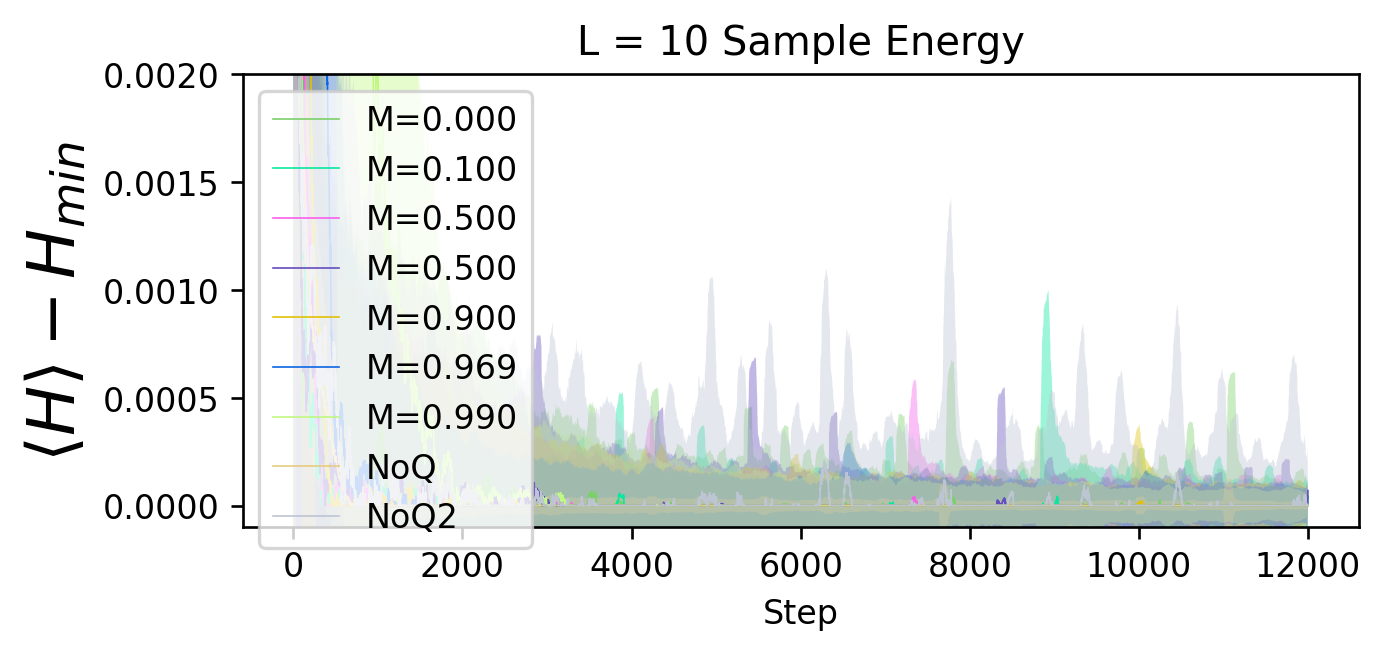

L=36 M=0.100: -1.263313|L=36 M=0.500: -1.263470|L=36 M=0.900: -1.263393|L=36 M=0.969: -1.263334|L=36 M=0.990: -1.263245|L=36 NoQ: -1.263250|L=36 NoQ2: -1.263294|


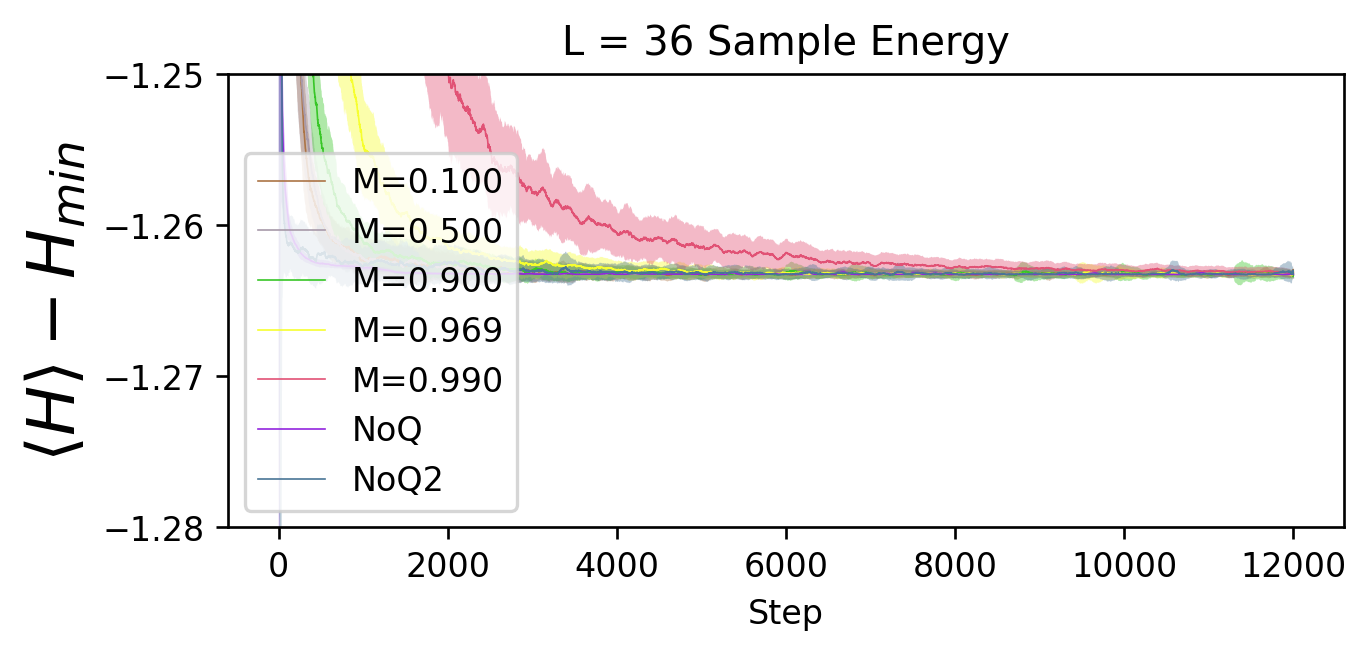

L=40 M=0.000: -1.264373|L=40 M=0.100: -1.264387|L=40 M=0.500: -1.264494|L=40 M=0.500: -1.264656|L=40 M=0.900: -1.264340|L=40 M=0.969: -1.264832|L=40 M=0.990: -1.264846|L=40 NoQ: -1.264241|L=40 NoQ2: -1.264375|


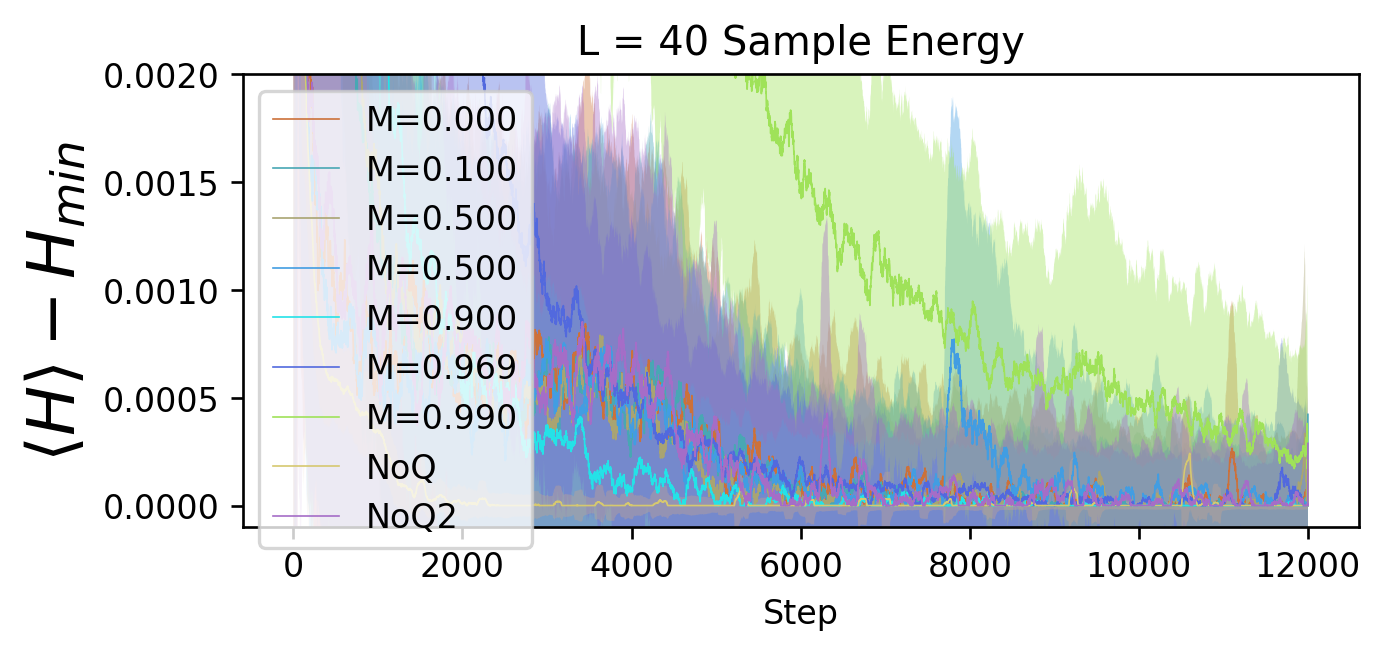

L=100 M=0.000: -1.269416|L=100 M=0.100: -1.269404|L=100 M=0.500: -1.270499|L=100 M=0.500: -1.270207|L=100 M=0.900: -1.269405|L=100 M=0.969: -1.269382|L=100 M=0.990: -1.266767|L=100 NoQ: -1.269633|L=100 NoQ: -1.269578|L=100 NoQ: -1.273170|L=100 NoQ: -1.270210|L=100 NoQ: -1.269558|L=100 NoQ: -1.269446|


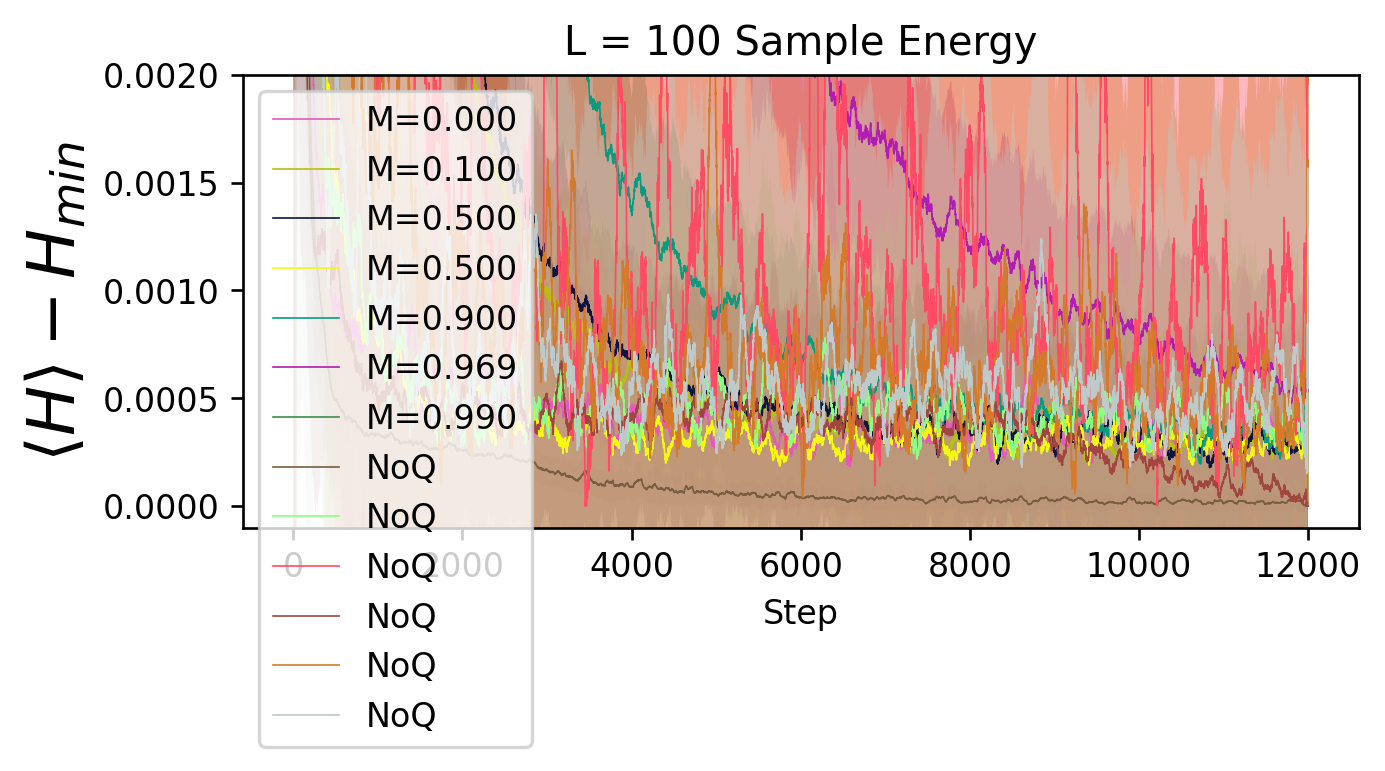

L=500 M=0.000: -1.272178|L=500 M=0.100: -1.270762|L=500 M=0.500: -1.270874|L=500 M=0.500: -1.272343|L=500 M=0.900: -1.267872|L=500 M=0.969: -1.256048|L=500 M=0.990: -1.207810|L=500 NoQ: -1.272521|L=500 NoQ: -1.272653|L=500 NoQ: -1.272426|L=500 NoQ: -1.272398|L=500 NoQ: -1.272430|


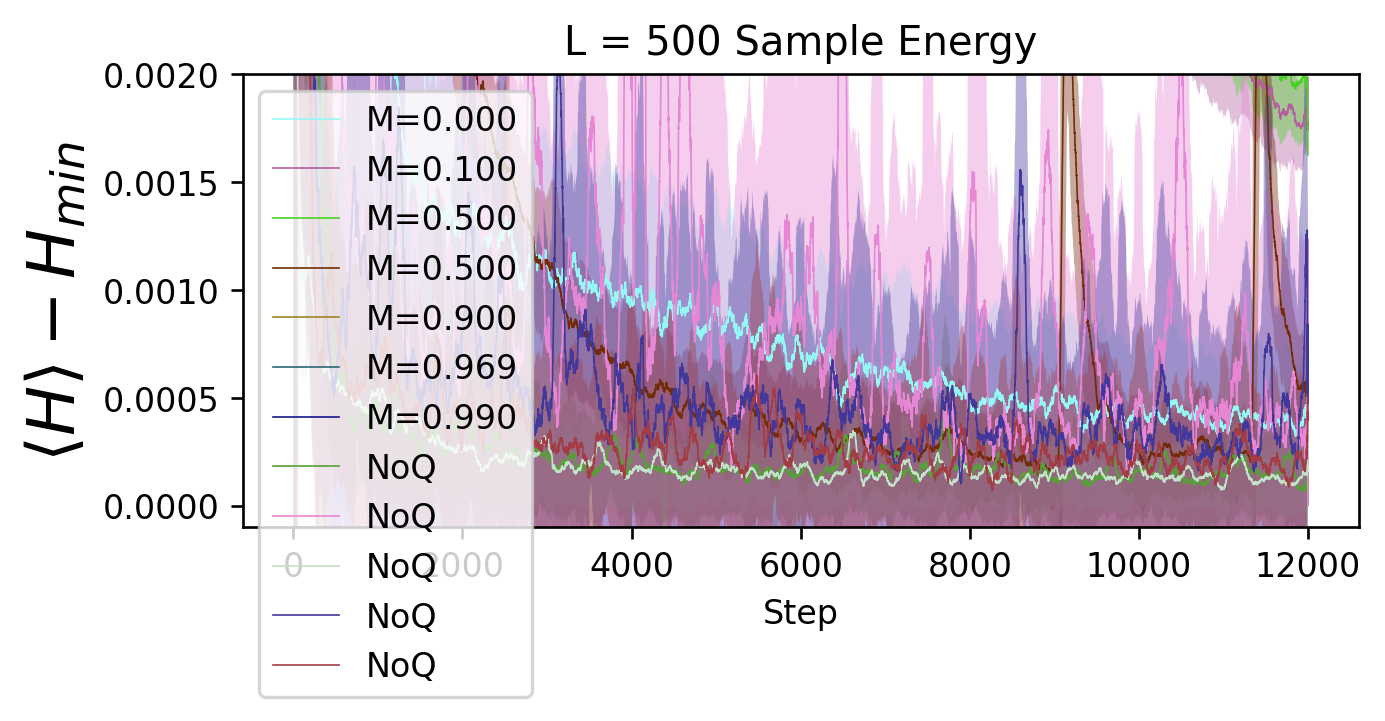

In [84]:
graphs(allpaths)

True -0.40522
L=64 K=32,Queue+KL: -0.404797|L=64 K=32,Queue: -0.398168|L=64 K=128,No Queue: -0.405186|L=64 K=32,No Queue: -0.398092|L=64 K=32,No Queue+KL: -0.396067|


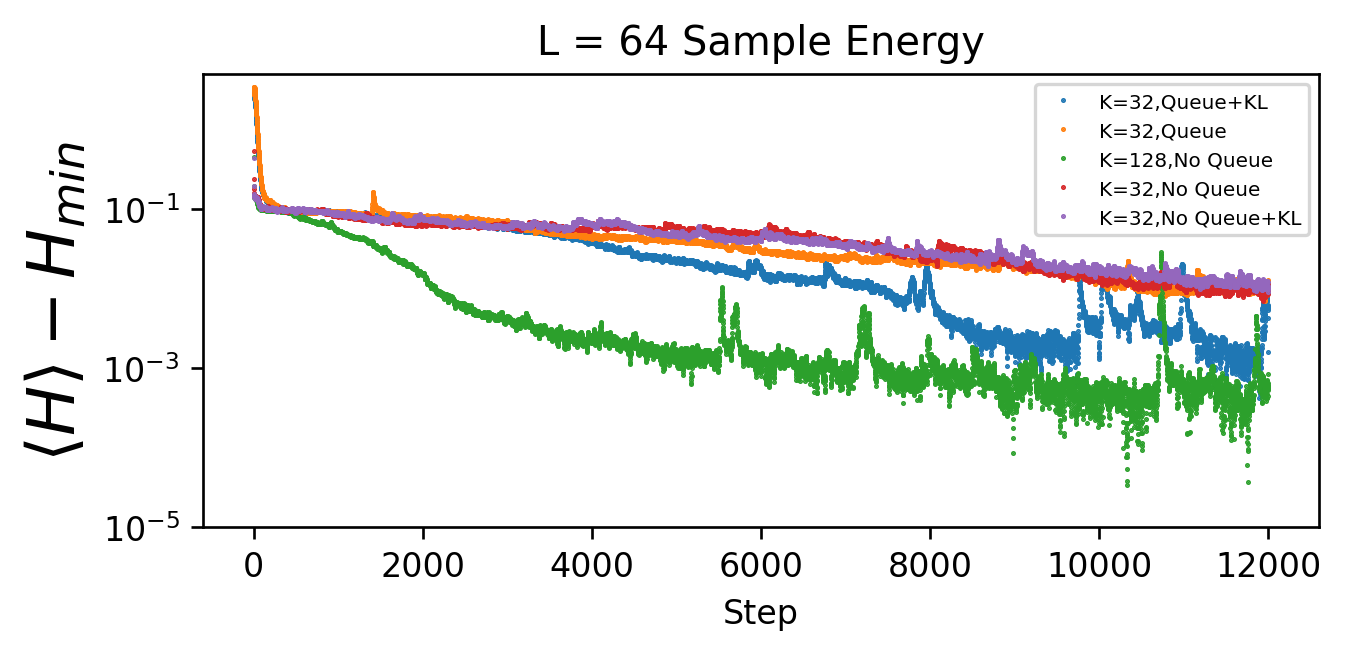

In [206]:
p = getpaths("TF\\Rydberg",["64","128-C","M"])
p2 = getpaths("TF\\Rydberg",["64","128-A","M"])
p3 = getpaths("TF\\Rydberg",["64","NoQ"])
p[64]+=p2[64]+p3[64]

graphs(p,label_idx=[3,-1],err=False,smoothing=10,useTimes=False)

True -0.40522
L=64 K=8,B=128,kl=0.00: -0.393637|L=64 K=8,B=128,kl=0.25: -0.404019|L=64 K=8,B=128,kl=0.50: -0.388601|L=64 K=128,B=128,No Queue: -0.405151|


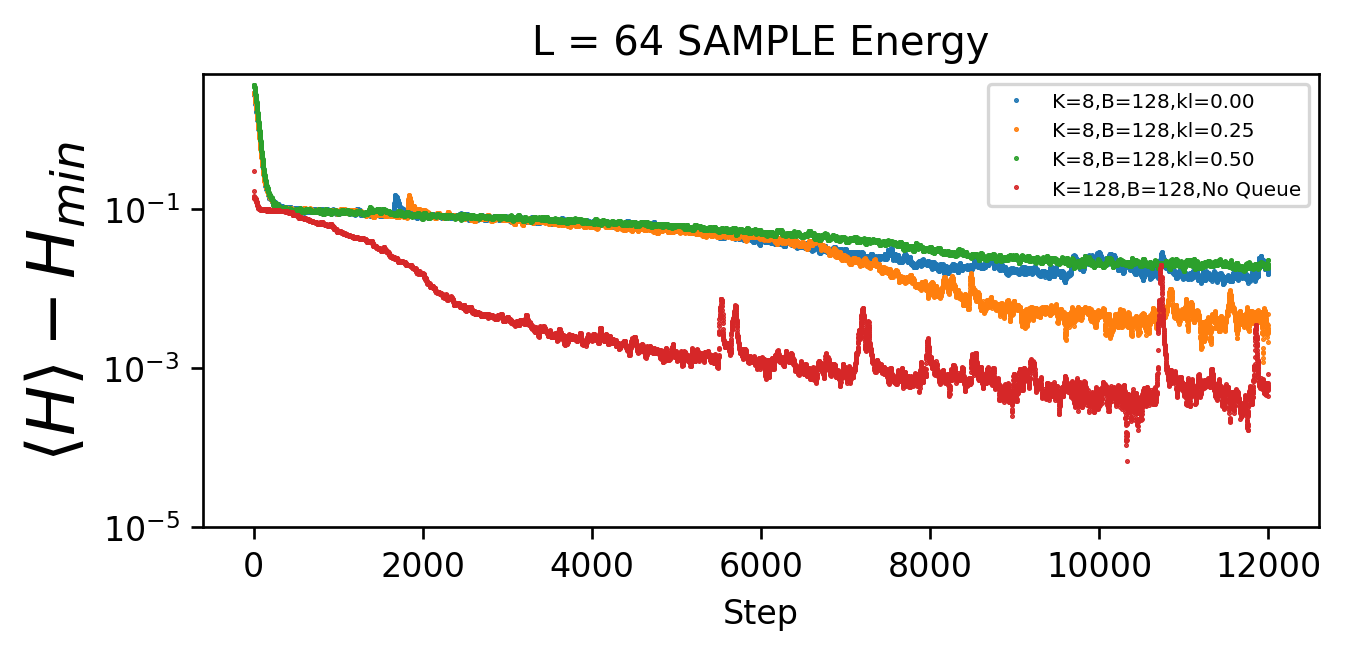

In [213]:
#p = getpaths("TF\\Rydberg",["64","C-Queue+KL"],alldir=True)
#p = getpaths("TF\\Rydberg",["64","A-Queue"],alldir=True)
#p = getpaths("TF\\Rydberg",["64","NoQ","B=32","128-A"],alldir=True)
#p = getpaths("TF\\Rydberg",["64","NoQ","B=32","128-B"],alldir=True)
#p[64]+=p2[64]+p3[64]
#p[64]=p[64][::-1]

p = getpaths("TF\\Rydberg",["kl","K=8"],alldir=False)
p2 = getpaths("TF\\Rydberg",["64","NoQ","B=128"],alldir=False)
p[64]+=p2[64]

graphs(p,label_idx=[3,2,-1],err=False,smoothing=20,useTimes=False,metric="SAMPLE")

In [ ]:
p = getpaths("TF\\Rydberg",["kl","K=8"],alldir=False)
p2 = getpaths("TF\\Rydberg",["64","NoQ","B=128"],alldir=False)
p[64]+=p2[64]

graphs(p,label_idx=[3,2,-1],err=False,smoothing=20,useTimes=False,metric="SAMPLE")

In [20]:

os.system("git commit -a -m \"Added kl divergence term\"")
os.system("git push origin")

0